In [27]:
import numpy as np
import scipy as sc
import time
from qiskit_entropy.utils import *
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
import json

In [38]:
# パラメータを取得
config = load_config('/home/mitsukism/qiskit_entropy/vn_ent_qubits8_training_config.json')

qubits = config["qubits"]
num_wires = config["num_wires"]
num_layers = config["num_layers"]
N = config["N"]
seed = config["seed"]
num_shots = config["num_shots"]
num_of_epochs = config["num_of_epochs"]
learning_rate = config["learning_rate"]
num_of_samples = config["num_of_samples"]
dimension = config["dimension"]
hidden_layer = config["hidden_layer"]

print("qubits: ", qubits)
print("num_wires: ", num_wires)
print("num_layers: ", num_layers)
print("N: ", N)
print("seed: ", seed)
print("num_shots: ", num_shots)
print("num_of_epochs: ", num_of_epochs)
print("learning_rate: ", learning_rate)
print("num_of_samples: ", num_of_samples)
print("dimension: ", dimension)
print("hidden_layer: ", hidden_layer)

device = qml.device("default.qubit", wires=num_wires, shots=num_shots)
@qml.qnode(device)
def measure_rho(param, circuit_structure, qubits, rotations=[qml.RX, qml.RY, qml.RZ]):
    obj_wires = range(qubits)   

    qml.Hadamard(wires=0)

    for gate_info in circuit_structure:
        gate = gate_info["gate"]
        wires = gate_info["wires"]
        if gate == "CNOT":
            qml.CNOT(wires=wires)
        elif gate == "PauliX":
            qml.PauliX(wires=wires[0])
        elif gate == "PauliY":
            qml.PauliY(wires=wires[0])
        elif gate == "PauliZ":
            qml.PauliZ(wires=wires[0])

    qml.RandomLayers(param, wires=obj_wires, rotations=rotations)

    result = [qml.sample(qml.PauliZ(i)) for i in range(len(obj_wires))]
    return result

class neural_function(nn.Module):
    def __init__(self,dimension,hidden_layer):
        super(neural_function, self).__init__()

        self.dimension = dimension
        self.hidden_layer = hidden_layer
        self.lin1 = nn.Linear(self.dimension, self.hidden_layer)
        self.lin_end = nn.Linear(self.hidden_layer, 1)

    def forward(self, input):
        y = torch.sigmoid(self.lin1(input.float()))
        y = self.lin_end(y)

        return y

qubits:  8
num_wires:  16
num_layers:  8
N:  256
seed:  42
num_shots:  10000
num_of_epochs:  1500
learning_rate:  0.01
num_of_samples:  10000
dimension:  8
hidden_layer:  16


In [39]:
num_of_samples = 1000
# initialize the neural network and quantum circuit parameters
neural_fn = neural_function(dimension, hidden_layer)
param_init = np.random.random(qml.RandomLayers.shape(n_layers=num_layers, n_rotations=3))
# intialize the cost function store
cost_func_store = []
circuit_structure = load_circuit_structure_from_json('/home/mitsukism/qiskit_entropy/circuit_structure_qubits8.json')
seed = 5

In [40]:
cost_func_store = []
# start the training
for epoch in range(1, num_of_epochs):
    
  # evaluate the gradient with respect to the quantum circuit parameters
    gradients = np.zeros_like((param_init))
    
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):

      # copy the parameters
            shifted = param_init.copy()

      # right shift the parameters
            shifted[i, j] += np.pi/2

      # forward evaluation
            result = measure_rho(shifted, circuit_structure, qubits)
            sample_result_array = np.array(result).T
            nn_result = neural_fn(torch.from_numpy(sample_result_array))
            forward_sum = nn_result[:, 0].detach().numpy().sum() / num_of_samples

      # left shift the parameters
            shifted[i, j] -= np.pi

      # backward evaluation
            backward_sum = 0
            result = measure_rho(shifted, circuit_structure, qubits)
            sample_result_array = np.array(result).T
            nn_result = neural_fn(torch.from_numpy(sample_result_array))
            backward_sum = nn_result[:, 0].detach().numpy().sum() / num_of_samples

      # parameter-shift rule
            gradients[i, j] = - 0.5 * (forward_sum - backward_sum)

  
    if epoch % 10 == 0:
        np.save(f"/home/mitsukism/qiskit_entropy/vn_net_gradients/qubits8/gradients_epoch{epoch}_seed{seed}.npy", gradients)

  # first copy the quantum circuit parameters before updating it
    prev_param_init = param_init.copy()

  # update the quantum circuit parameters
    param_init -= learning_rate*gradients

  # evaluate the gradient with respect to the NN parameters
    optimizer = optim.SGD(neural_fn.parameters(), lr=learning_rate)

  # evaluate the first term
    loss = 0
    result = measure_rho(prev_param_init, circuit_structure, qubits)
    for sample in range(num_of_samples):
        # optimizer.zero_grad()
        sample_result_array = np.array([result[q][sample] for q in range(dimension)])
        random_result_array = np.random.choice([-1, 1], size=dimension)
        sample_nn_result = neural_fn(torch.from_numpy(sample_result_array))
        random_nn_result = neural_fn(torch.from_numpy(random_result_array))
        loss_term = (torch.exp(random_nn_result[0]) - sample_nn_result[0]).to("cpu")
        loss += loss_term / num_of_samples
    loss.backward()
    torch.nn.utils.clip_grad_norm_(neural_fn.parameters(), max_norm=1.0)
    optimizer.step()

  # evaluate the cost function at these parameters
    first_term = 0
    result = measure_rho(param_init, circuit_structure, qubits)
    for sample in range(num_of_samples):
        sample_result_array = np.array([result[q][sample] for q in range(dimension)])
        nn_result = neural_fn(torch.from_numpy(sample_result_array))
        first_term += nn_result[0].detach().numpy()

  # normalize the cost sum
    first_term = first_term/num_of_samples

  # # Second term evaluation
    second_term = 0
    for sample in range(num_of_samples):
        result = np.random.choice([-1, 1], size=dimension)
        nn_result = neural_fn(torch.from_numpy(result.flatten()))
        second_term += np.exp(nn_result[0].detach().numpy())

  # normalize the second term sum
    second_term = second_term/num_of_samples

    # add the cost function to the store
    cost_func_store.append(np.log(N) - first_term + second_term - 1)
    print(f"Epoch: {epoch}, Cost: {cost_func_store[-1]}")
  # save the cost function
    # np.save(f"/home/mitsukism/qiskit_entropy/vn_net_cost/qubits10/cost_epoch{epoch}_seed{seed}.npy", cost_func_store)

Epoch: 1, Cost: 5.638371153227188
Epoch: 2, Cost: 5.628445976383187
Epoch: 3, Cost: 5.627438209167816
Epoch: 4, Cost: 5.617855472258427
Epoch: 5, Cost: 5.610860193691351
Epoch: 6, Cost: 5.604390758759476
Epoch: 7, Cost: 5.594562400422193
Epoch: 8, Cost: 5.589791502035356
Epoch: 9, Cost: 5.5866377055115475
Epoch: 10, Cost: 5.584928891568579
Epoch: 11, Cost: 5.574263414665259
Epoch: 12, Cost: 5.567421402777679
Epoch: 13, Cost: 5.56524856206695
Epoch: 14, Cost: 5.563058820123918
Epoch: 15, Cost: 5.558752233400144
Epoch: 16, Cost: 5.55452081375862
Epoch: 17, Cost: 5.550299180633522
Epoch: 18, Cost: 5.547774563639559
Epoch: 19, Cost: 5.545956616184808
Epoch: 20, Cost: 5.542932081907191
Epoch: 21, Cost: 5.539166086285509
Epoch: 22, Cost: 5.537675617470541
Epoch: 23, Cost: 5.536951883948542
Epoch: 24, Cost: 5.533705057344533
Epoch: 25, Cost: 5.53267558487425
Epoch: 26, Cost: 5.5287356935061
Epoch: 27, Cost: 5.525825572780468
Epoch: 28, Cost: 5.523604907087185
Epoch: 29, Cost: 5.52244451776812

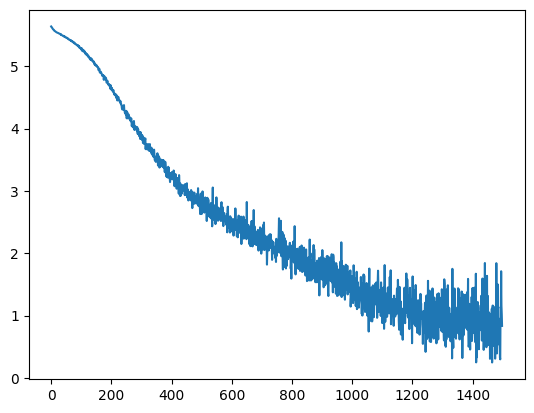

In [41]:
import matplotlib.pyplot as plt
plt.plot(cost_func_store)

In [48]:
np.save(f"./cost_qubits{qubits}_seed{seed}.npy", cost_func_store)

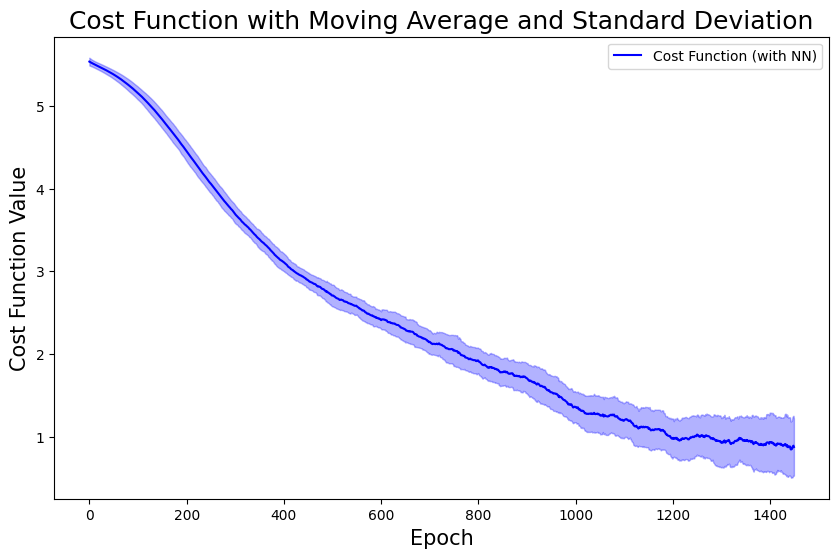

In [42]:
# 移動平均を計算する関数を定義
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 移動平均と標準偏差を計算
window_size = 50  # ウィンドウサイズを50とする
rolling_mean = moving_average(cost_func_store, window_size)
rolling_std = np.std([cost_func_store[i:i+window_size] for i in range(len(cost_func_store)-window_size+1)], axis=1)

# グラフの描画
plt.figure(figsize=(10, 6))

# 移動平均のプロット
plt.plot(rolling_mean, label='Cost Function (with NN)', color='blue', linewidth=1.5)

# 標準偏差を基に塗りつぶしを追加
plt.fill_between(range(len(rolling_mean)), rolling_mean - rolling_std, rolling_mean + rolling_std, color='blue', alpha=0.3)

# 軸ラベルとタイトルを追加
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Cost Function Value', fontsize=15)
plt.title('Cost Function with Moving Average and Standard Deviation', fontsize=18)

# 凡例の追加
plt.legend()

# グラフを表示
plt.show()